In [38]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import h5py

# RH FILTER

## Generating / plotting plant filter

83


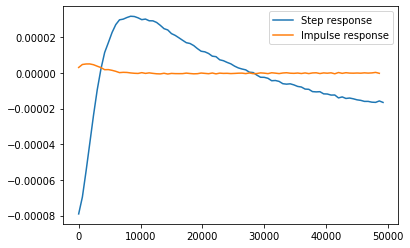

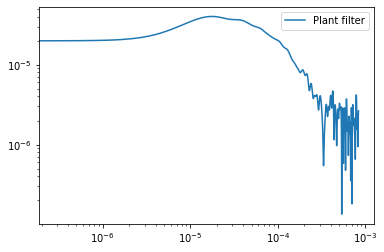

4.993706070287539e-06


In [39]:
ITMYRH_data = np.loadtxt('../data/ITMY_trend_10min_int_longer.dat')
t = np.arange(0,len(ITMYRH_data[:,0][2:]))*60.0*10.0
normalize = 3.13
print(len(t))
data_in = ITMYRH_data[:,1][2:]
b, a = signal.butter(2, .2)
#data_new = signal.filtfilt(b,a,data_in)
data_new = data_in
plt.figure()
ir = (data_new[1:] - data_new[:-1])/normalize
ir_new = ir
plt.plot(t, data_new, label='Step response')
plt.plot(t[:(len(t)-1)], ir, label= 'Impulse response')
plt.legend()
plt.show()

Fs = 1/(t[2]-t[1])
#print(Fs)

[F,H]=signal.freqz(ir_new,1, worN=3000,whole=False) 
plt.figure()
plt.loglog(F*Fs/(2*np.pi), abs(H), label='Plant filter')
plt.legend()
plt.show()


#results = IIRrational.v2.data2filter(
#    data = abs(H),
#    F_Hz = F,
#)
print(max(ir_new))

In [91]:
print('Only plots up to the nyqist frequency: {} Hz'.format(F[-1]*Fs/(2*np.pi)))

Only plots up to the nyqist frequency: 0.0008330555555555556 Hz


9.729529652779821e-12


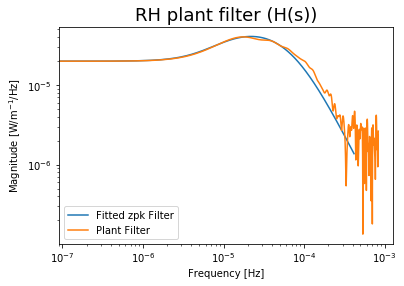

In [53]:
#model =  zpk(-2*pi*5e-6, -2.*pi.*[1.3e-5; 9.5e-5; 5e-5],1);

zeros = 5.0e-6
fit_zeros = -2.0*np.pi*5.0e-6
poles = np.array([1.3e-5, 5.0e-5 ,9.5e-5])
fit_poles = -2.0*np.pi*poles

k = 1 #This gain is not initally correct

s1 = signal.ZerosPolesGain(fit_zeros, fit_poles, k)
F_2, H_2 = signal.freqresp(s1, F*(Fs/2.0))

#[F_2,H_2] = signal.freqs(b_2, a_2)
k_new = abs(H[0])/abs(H_2[0])

plt.loglog(F_2/(2*np.pi), abs(H_2)*k_new, label='Fitted zpk Filter')
plt.loglog(F/(2*np.pi)*Fs, abs(H), label='Plant Filter')
plt.ylabel('Magnitude [W/m$^{-1}$/Hz]')
plt.xlabel('Frequency [Hz]')
plt.legend()
plt.title('RH plant filter (H(s))',FontSize=18)

print(k_new) #Spit out the new gain

model_zpk = signal.ZerosPolesGain(fit_zeros, fit_poles,k_new)

## Now to invert the plant filter (just swapping the poles and the zeros and inverting gain) (H$^{-1}$(s))

Text(0.5, 1.0, 'RH inverse filter (H$^{-1}$(s))')

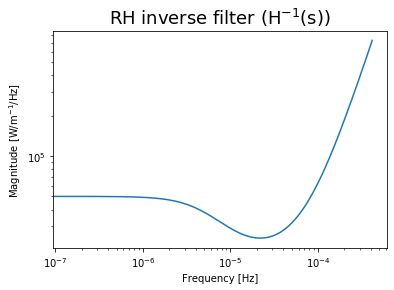

In [55]:
inv_model = signal.ZerosPolesGain(fit_poles, fit_zeros,1/k_new)
F_3, H_3 = signal.freqresp(inv_model, F*(Fs/2.0))
plt.loglog(F_3/(2*np.pi), abs(H_3), label='Fitted zpk Filter')
plt.ylabel('Magnitude [W/m$^{-1}$/Hz]')
plt.xlabel('Frequency [Hz]')
plt.title('RH inverse filter (H$^{-1}$(s))',FontSize=18)

## Stabilize the high frequencies to DC

Text(0.5, 1.0, 'RH input conditioning filter (H$^{-1*}$(s))')

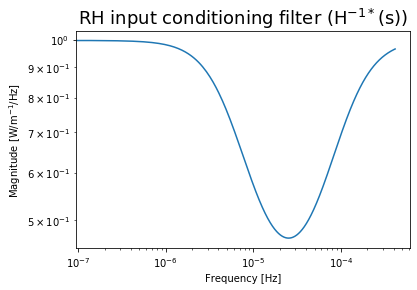

In [60]:
rh_input_filter = signal.ZerosPolesGain(fit_poles, [fit_zeros,-2.0*np.pi*.0001113129672, -2.0*np.pi*.0001113129672],1)
F_4, H_4 = signal.freqresp(rh_input_filter,F*(Fs/2.0))
plt.loglog(F_4/(2*np.pi), abs(H_4), label='Fitted zpk Filter')
plt.ylabel('Magnitude [W/m$^{-1}$/Hz]')
plt.xlabel('Frequency [Hz]')
plt.title('RH input conditioning filter (H$^{-1*}$(s))',FontSize=18)

0.9999741188362085

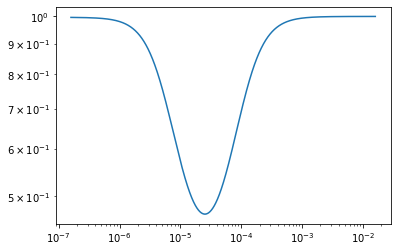

In [127]:
freq = np.arange(10e-7,10e-2,1e-7)
F_4_longer, H_4_longer = signal.freqresp(rh_input_filter,freq)
plt.loglog(freq/(2*np.pi), abs(H_4_longer), label='Fitted zpk Filter')

max(abs(H_4_longer))

# COMSOL self heating filter

## Import COMSOL self heating data

In [260]:
COM_data = np.loadtxt('../data/1W_self_heating_defocus_doublepass.txt')
t_com = COM_data[:,0]*3600
defocus = COM_data[:,1]

Text(0, 0.5, 'defocus [arb]')

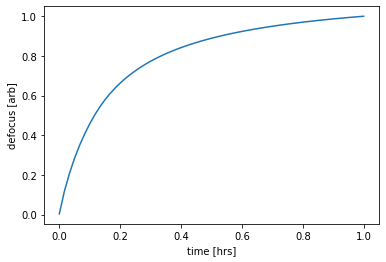

In [261]:
plt.plot(t_com/3600,defocus/np.max(defocus))
plt.xlabel('time [hrs]')
plt.ylabel('defocus [arb]')

In [309]:
ir_com  = (defocus[1:] - defocus[:-1])
t_ir = t_com[:((len(t_com)-1))]

In [315]:
[F_ir,H_ir]=signal.freqz(ir_com, 1, worN=3000,whole=False) 
Fs_com =1/(t_com[1]-t_com[0])

Text(0.5, 1.0, 'Self Heating filter (G$_{2}$(s))')

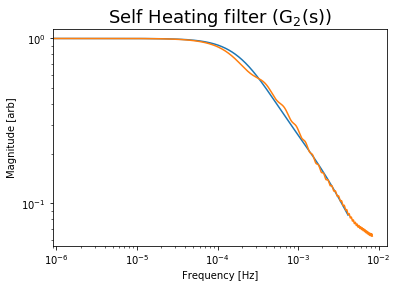

In [423]:
zeros_com = np.array([.9e-3,.3e-3])
fit_zeros_com = -2.0*np.pi*zeros_com
poles_com = np.array([.25e-3,.25e-3,1.6e-3])
fit_poles_com = -2.0*np.pi*poles_com

k_com =1 #This gain is not initally correct

zpk_com = signal.ZerosPolesGain(fit_zeros_com, fit_poles_com, k_com)
F_com, H_com = signal.freqresp(zpk_com, F_ir*(Fs_com/2.0))
k_new_com = abs(H_ir[0])/abs(H_ir[0]*H_com[0])

plt.loglog(F_com/(2*np.pi), abs(H_com)*k_new_com, label='Fitted zpk Filter')
plt.loglog(F_ir*Fs_com/(2*np.pi), abs(H_ir)/abs(H_ir[0]), label='Plant filter')
plt.ylabel('Magnitude [arb]')
plt.xlabel('Frequency [Hz]')
plt.title('Self Heating filter (G$_{2}$(s))',FontSize=18)


In [424]:
G_2 = signal.ZerosPolesGain(fit_zeros_com, fit_poles_com, k_new_com)
unit_step_testing = np.zeros(np.shape(t_com))
unit_step_testing[t_com>0] = 1
[ _ ,y_self_test, _] = signal.lsim(G_2, unit_step_testing, t_com)

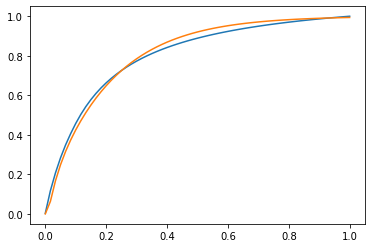

In [425]:
plt.plot(t_com/3600,defocus/np.max(defocus))
plt.plot(t_com/3600,y_self_test)

# Generating the proper time series

In [426]:
lin_thickness=4
title_font = {'fontname':'Arial', 'size':'30', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'fontname':'Arial', 'size':'16'}

In [427]:
unit_step = np.zeros((t.shape[0]*25))
t_new = np.arange(0,len(unit_step))*60.0*1.0
## Generating simulated response
unit_step[t_new>36000] = 1
[t_mod_new,y_mod_sim,xout] = signal.lsim(model_zpk, unit_step, t_new)

In [428]:
[ _ ,y_inp_inv, _] = signal.lsim(rh_input_filter, unit_step, t_new)
[ _ ,y_mod_sim_inv, _] = signal.lsim(model_zpk, y_inp_inv, t_new)

In [429]:
unit_step2 = np.zeros((t.shape[0]*25))
unit_step2[t_new>37750] = 1

In [430]:
[ _ ,y_sh_resp, _] = signal.lsim(G_2, unit_step2, t_new)

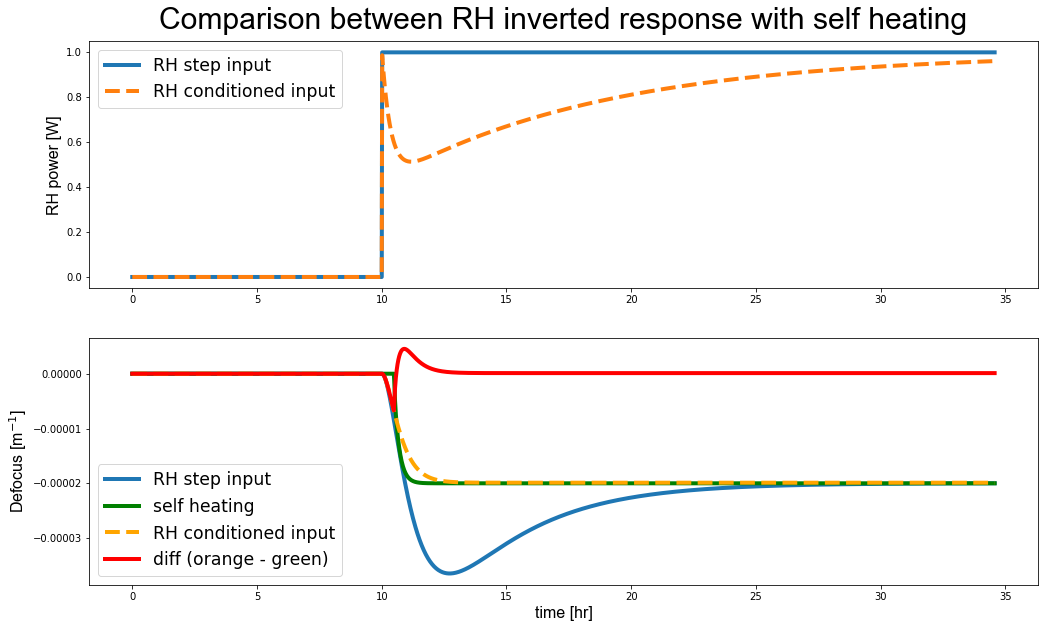

In [431]:
fig = plt.figure(figsize=(17,10))
plt.subplot(211)
plt.plot(t_new/3600, unit_step,linewidth = lin_thickness,label='RH step input')
plt.plot(t_new/3600, y_inp_inv,'--', linewidth = lin_thickness,label='RH conditioned input')
plt.ylabel('RH power [W]',**axis_font)
plt.title('Comparison between RH inverted response with self heating',**title_font)
plt.legend(fontsize='xx-large')
plt.subplot(212)
plt.plot(t_new/3600,-y_mod_sim, linewidth = lin_thickness,label = 'RH step input')
plt.plot(t_new/3600,-y_sh_resp*20e-6, linewidth = lin_thickness,color='green',label ='self heating')
plt.plot(t_new/3600,-y_mod_sim_inv,'--', linewidth = lin_thickness,color='orange',label ='RH conditioned input')
plt.plot(t_new/3600,y_sh_resp*20e-6 -y_mod_sim_inv,linewidth = lin_thickness,label='diff (orange - green)',color='red')
plt.ylabel('Defocus [m$^{-1}$]',**axis_font)
plt.xlabel('time [hr]',**axis_font)
plt.legend(fontsize='xx-large')
fig.savefig('IRHF_compare_w_self.pdf')

In [432]:
sum(abs(y_sh_resp*20e-6 -y_mod_sim_inv))

0.0004976846026911539

# G$_{1}$(s) -> The "response function"

Text(0.5, 0, 'Frequency [Hz]')

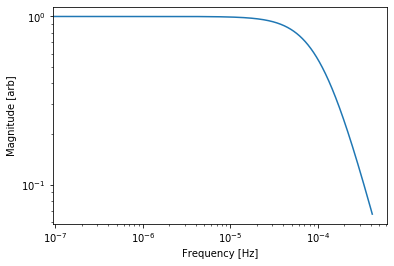

In [433]:
#For the above scenario we have the following G_s (a double pole low pass at 1.113e-4)
G_1 = signal.ZerosPolesGain([], [-2.0*np.pi*.0001113129672, -2.0*np.pi*.0001113129672],1)
F_5, H_5 = signal.freqresp(G_1,F*(Fs/2.0))
k_upd = 1/abs(H_5[0])
G_1 = signal.ZerosPolesGain([], [-2.0*np.pi*.0001113129672, -2.0*np.pi*.0001113129672],k_upd)
plt.loglog(F_5/(2*np.pi), abs(H_5)*k_upd, label='Fitted zpk Filter')
plt.ylabel('Magnitude [arb]')
plt.xlabel('Frequency [Hz]')

#### Deriving the above filter is achieved by assuming a double pole solution. We are using poles in order to reduce the gain at relatively high frequency (to avoid implementing a unstable and unphysical filter. The reason we need two is to balance out the number of poles and zeros. The value of the chosen pole frequency is achieved by setting the ratio of the poles to zeros equal to 1.

# Alternative response function (G$_{2}$(s) w/ self heating?)

## To preface this discussion, the 2nd order low pass filter appears to be one of two solutions: 
    ## At Hanford we use the 2nd order low pass (G$_{1}$(s) but as of this moment is not used to perform dynamic thermal compensation.
    ## At Livinston they use the self heating response to inform the final form of their filter

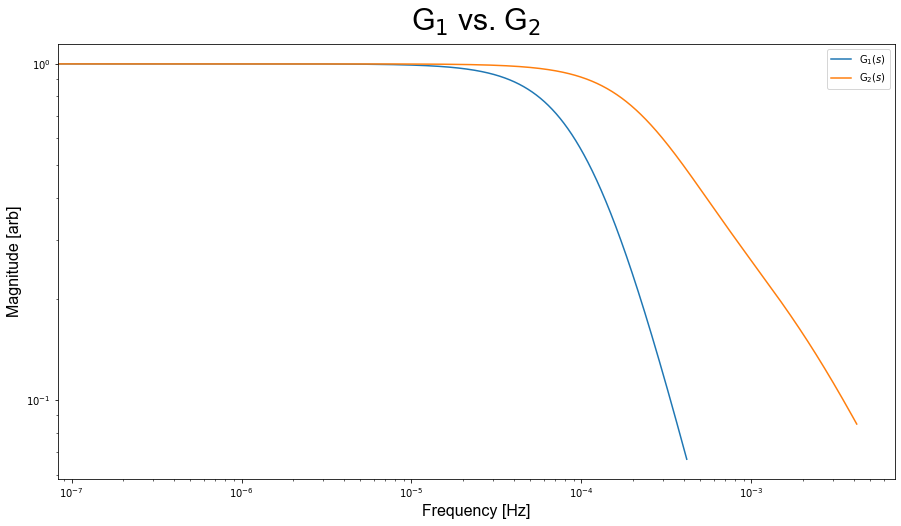

In [434]:
fig2 = plt.figure(figsize=(15,8))
plt.loglog(F_5/(2*np.pi), abs(H_5)*k_upd, label='G$_{1}(s)$')
plt.loglog(F_com/(2*np.pi), abs(H_com)*k_new_com, label='G$_{2}(s)$')
plt.ylabel('Magnitude [arb]',**axis_font)
plt.xlabel('Frequency [Hz]',**axis_font)
plt.title('G$_{1}$ vs. G$_{2}$',**title_font)
plt.legend()

## The Livingston filter is what we will construct here. To do that, we will first attempt multiplying G$_{2}$(s) (the self heating response) to H$^{-1}$(s)

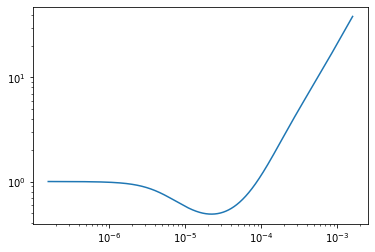

In [435]:
FILT_LIV_zeros= np.append(fit_zeros_com,fit_poles)
FILT_LIV_poles= np.append(fit_poles_com,fit_zeros)
FILT_LIV = signal.ZerosPolesGain(FILT_LIV_zeros, FILT_LIV_poles, 1)
_ , H_G2 = signal.freqresp(FILT_LIV,np.arange(10e-7,10e-3,1e-7))
plt.loglog(np.arange(10e-7,10e-3,1e-7)/(2*np.pi), abs(H_G2)/abs(H_G2[0]))

## Not enough zeros to set high frequency to unity gain (would be an unphysical without one more pole)

In [438]:
FILT_LIV_poles_2= np.append(FILT_LIV_poles,-0.00020951281288038756)

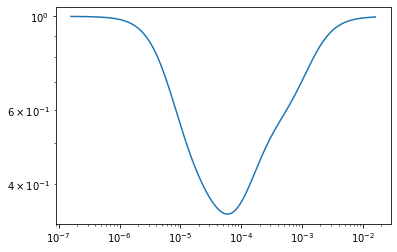

In [439]:
FILT_LIV = signal.ZerosPolesGain(FILT_LIV_zeros, FILT_LIV_poles_2, 1)
_ , H_G2 = signal.freqresp(FILT_LIV,freq)
plt.loglog(freq/(2*np.pi), abs(H_G2)/abs(H_G2[0]))

In [440]:
[ _ ,y_G2, _] = signal.lsim(FILT_LIV, unit_step, t_new)

In [441]:
[ _ ,y_G2_time, _] = signal.lsim(model_zpk, y_G2, t_new)

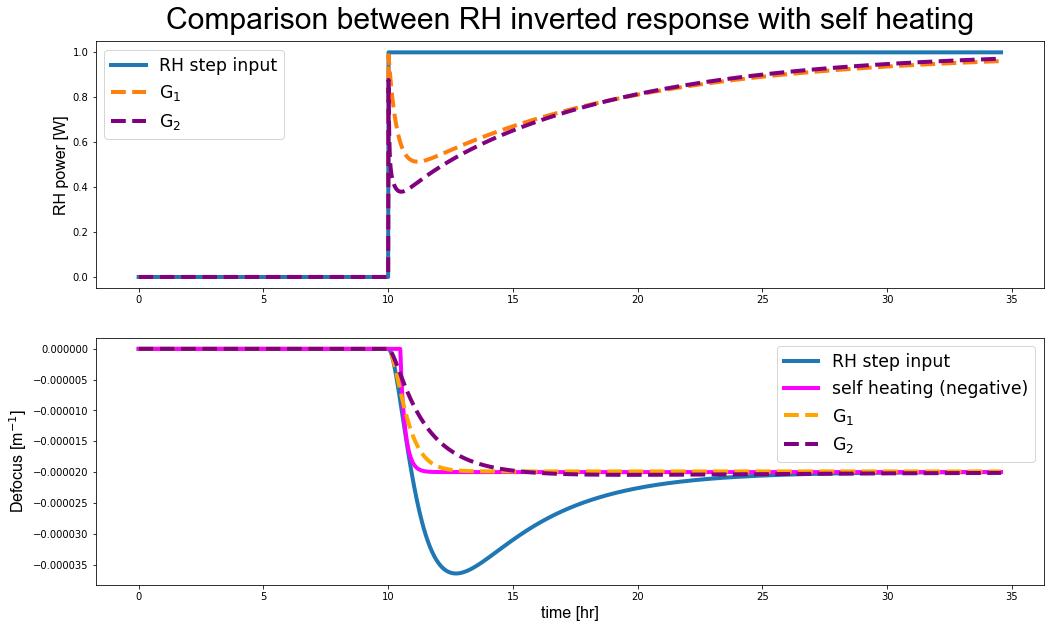

In [445]:
fig = plt.figure(figsize=(17,10))
plt.subplot(211)
plt.plot(t_new/3600, unit_step,linewidth = lin_thickness,label='RH step input')
plt.plot(t_new/3600, y_inp_inv,'--', linewidth = lin_thickness,label='G$_{1}$')
plt.plot(t_new/3600,y_G2,'--', linewidth = lin_thickness,color='purple',label ='G$_{2}$')
plt.ylabel('RH power [W]',**axis_font)
plt.title('Comparison between RH inverted response with self heating',**title_font)
plt.legend(fontsize='xx-large')
plt.subplot(212)
plt.plot(t_new/3600,-y_mod_sim, linewidth = lin_thickness,label = 'RH step input')
plt.plot(t_new/3600,-y_sh_resp*20e-6, linewidth = lin_thickness,color='magenta',label ='self heating (negative)')
plt.plot(t_new/3600,-y_mod_sim_inv,'--', linewidth = lin_thickness,color='orange',label ='G$_{1}$')
#plt.plot(t_new/3600,y_sh_resp*20e-6 -y_mod_sim_inv,linewidth = lin_thickness,label='diff (orange - green)',color='red')
plt.plot(t_new/3600,-y_G2_time,'--', linewidth = lin_thickness,color='purple',label ='G$_{2}$')
plt.ylabel('Defocus [m$^{-1}$]',**axis_font)
plt.xlabel('time [hr]',**axis_font)
plt.legend(fontsize='xx-large')
fig.savefig('G1_and_G2.pdf')